In [4]:
import os

In [5]:
%pwd

'c:\\Users\\RICH-FILES\\Desktop\\ml\\Loan-Amount-Prediction\\research'

In [6]:
os.chdir("../")

In [7]:
%pwd

'c:\\Users\\RICH-FILES\\Desktop\\ml\\Loan-Amount-Prediction'

In [8]:
project_path = "C:/Users/RICH-FILES/Desktop/ml/Loan-Amount-Prediction"

os.chdir(project_path)

In [9]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class ModelTrainerConfig:
    root_dir: Path
    train_data_path: Path
    test_data_path: Path
    model_name: str
    n_estimators: int
    max_depth:  int
    min_samples_split: int
    min_samples_leaf: int
    target_column: float
    

In [10]:
from credit_risk.constants import *
from credit_risk.utils.common import read_yaml, create_directories




In [11]:
#creating a Configuration class
class ConfigurationManager:
    def __init__(
        self,
        config_filepath   = CONFIG_FILE_PATH,
        params_filepath   = PARAMS_FILE_PATH,
        schema_filepath   = SCHEMA_FILE_PATH):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)                       
        self.schema = read_yaml(schema_filepath)
        
        create_directories([self.config.artifacts_root])
    
    def get_model_trainer_config(self)->ModelTrainerConfig:
        config = self.config.model_trainer
        params = self.params.RandomForestRegressor
        schema = self.schema.TARGET_COLUMN
        
        create_directories([config.root_dir])
        
        model_trainer_config = ModelTrainerConfig(
            root_dir = config.root_dir,
            train_data_path=config.train_data_path,
            test_data_path=config.test_data_path,
            model_name = config.model_name,
            n_estimators=params.n_estimators,
            max_depth=params.max_depth,
            min_samples_split=params.min_samples_split,
            min_samples_leaf=params.min_samples_leaf,
            target_column=schema.name
        )
        
        return model_trainer_config
    
   
        
        
    
        

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import joblib
import os
from sklearn.model_selection import GridSearchCV 
from joblib import parallel_backend
import shap
import matplotlib.pyplot as plt



class ModelTrainer:
    def __init__(self, config):
        self.config = config
        
    def train(self):
        train_data = pd.read_csv(self.config.train_data_path)
        test_data = pd.read_csv(self.config.test_data_path)

        train_data.dropna(inplace=True)
        test_data.dropna(inplace=True)

        train_x = train_data.drop([self.config.target_column], axis=1)
        test_x = test_data.drop([self.config.target_column], axis=1)
        train_y = train_data[self.config.target_column]
        test_y = test_data[self.config.target_column]

        numerical_features = ["Income", "Emp_length", "Rate", "Percent_income"]
        categorical_features = ["Home", "Intent"]

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", StandardScaler(), numerical_features),
                ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
            ]
        )

        # Check One-Hot Encoding Output Before Model Fitting
        train_x_transformed = preprocessor.fit_transform(train_x)
        test_x_transformed = preprocessor.transform(test_x)

        print("Transformed train_x shape:", train_x_transformed.shape)
        print("Transformed test_x shape:", test_x_transformed.shape)
        
        # Proceed with the pipeline
        model_pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("model", RandomForestRegressor(
                n_estimators=self.config.n_estimators,
                max_depth=self.config.max_depth,
                min_samples_leaf=self.config.min_samples_leaf,
                min_samples_split=self.config.min_samples_split,
                random_state=42))
        ])

        model_pipeline.fit(train_x, train_y)

        # Save the pipeline
        joblib.dump(model_pipeline, os.path.join(self.config.root_dir, self.config.model_name))

       
        
        #model evaluation with GridSearchCV
        param_grid = {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [10, 20, 30],
            'model__min_samples_split': [2, 5, 10],
         'model__min_samples_leaf': [1, 2, 4]
        }

        
        
        grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, n_jobs= 4, verbose=2)
        
        with parallel_backend('threading'):
            grid_search.fit(train_x, train_y)
          
        
        print("Best Parameters:", grid_search.best_params_) 
        
        #Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}
        
        #Save the pipeline
        joblib.dump(grid_search, os.path.join(self.config.root_dir, self.config.model_name))
        
        #train_x_transformed = preprocessor.transform(train_x)  # Ensure this matches model training


        # Ensure train_x is fully transformed before passing it to SHAP
        train_x_transformed = model_pipeline.named_steps["preprocessor"].transform(train_x)

        # Get the trained model
        best_model = grid_search.best_estimator_.named_steps["model"]

        # Initialize SHAP Explainer with transformed numerical data
        explainer = shap.Explainer(best_model, train_x_transformed)

        # Compute SHAP values
        shap_values = explainer(train_x_transformed, check_additivity=False)

        # Plot feature importance
        shap.summary_plot(shap_values, train_x_transformed)

        # Save the SHAP values
        joblib.dump(shap_values, os.path.join(self.config.root_dir, "shap_values")) 
        
        # accessing feature names
        feature_names = list(train_x.columns)

        # Create a mapping dictionary
        feature_mapping = {f'Feature {i}': feature_names[i] for i in range(len(feature_names))}

        # Print the mapping
        print(feature_mapping)
        
        # Save the feature mapping
        joblib.dump(feature_mapping, os.path.join(self.config.root_dir, "feature_mapping"))


        return grid_search.best_estimator_
    
    #Features importance
    
    #{'Feature 0': 'Income',
    # 'Feature 1': 'Home', 
    # 'Feature 2': 'Emp_length',
    # 'Feature 3': 'Intent',
    # 'Feature 4': 'Rate',
    # 'Feature 5': 'Percent_income',
    # 'Feature 6': 'Cred_length'

    #Feature Selection
    #Based on the SHAP values, we can see that the most important features are: Income, Intent and Emp_length.
   
               
       

[2025-03-24 20:04:36,775: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-03-24 20:04:36,778: INFO: common: yaml file: params.yaml loaded successfully]
[2025-03-24 20:04:36,783: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-03-24 20:04:36,785: INFO: common: created directory at: artifacts]
[2025-03-24 20:04:36,792: INFO: common: created directory at: artifacts/model_trainer]
Transformed train_x shape: (19968, 14)
Transformed test_x shape: (4993, 14)
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   4.8s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   4.9s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   5.0s
[CV] END model__max_depth=10, model__min_samples_leaf=1,

100%|===================| 19954/19968 [23:43<00:00]        

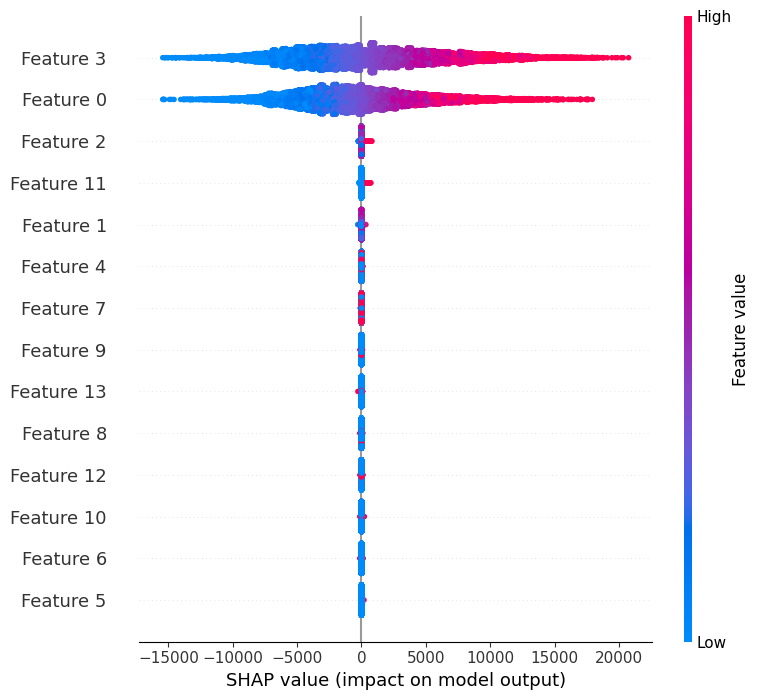

{'Feature 0': 'Income', 'Feature 1': 'Home', 'Feature 2': 'Emp_length', 'Feature 3': 'Intent', 'Feature 4': 'Rate', 'Feature 5': 'Percent_income', 'Feature 6': 'Cred_length'}


In [13]:
#define pipeline
try:
    config = ConfigurationManager()
    model_trainer_config = config.get_model_trainer_config()
    model_trainer_config=ModelTrainer(config=model_trainer_config)
    model_trainer_config.train()
except Exception as e:
    raise e    